In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.models import resnet50

from data import get_bloodmnist_loader
from utils import *

!nvidia-smi

/h/lkcai/anaconda3/envs/video_comp_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Thu Nov 28 17:09:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   54C    P8    17W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
train_loader = get_bloodmnist_loader(split='train', batch_size=64)
val_loader = get_bloodmnist_loader(split='val', batch_size=100, shuffle=False)

Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /h/lkcai/.medmnist/bloodmnist_128.npz


# Finetune linear layer with a ImageNet supervised pretrained backbone

In [3]:
num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sup_model = resnet50(pretrained=True)
for name, param in sup_model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

sup_model.fc = nn.Linear(sup_model.fc.in_features, num_classes)
sup_model.fc.weight.data.normal_(mean=0.0, std=0.01)
sup_model.fc.bias.data.zero_()
sup_model = sup_model.to(device)

parameters = list(filter(lambda p: p.requires_grad, sup_model.parameters()))
optimizer = optim.Adam(parameters, 0.01)

criterion = nn.CrossEntropyLoss()

# pre-trained classifier with random head
val_acc = validate(sup_model, val_loader, device)
print(f"Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Pretrained Classifier with Random head - Val Acc: 16.88% 


100%|██████████| 187/187 [01:21<00:00,  2.30it/s]


[Epoch 1/10]: Train Loss: 1.2833 Train Acc: 68.04% | Val Acc: 68.98%


100%|██████████| 187/187 [01:20<00:00,  2.32it/s]


[Epoch 2/10]: Train Loss: 0.6566 Train Acc: 79.01% | Val Acc: 66.76%


100%|██████████| 187/187 [01:19<00:00,  2.34it/s]


[Epoch 3/10]: Train Loss: 0.7184 Train Acc: 78.45% | Val Acc: 62.56%


100%|██████████| 187/187 [01:17<00:00,  2.40it/s]


[Epoch 4/10]: Train Loss: 0.6626 Train Acc: 80.67% | Val Acc: 86.21%


100%|██████████| 187/187 [01:19<00:00,  2.37it/s]


[Epoch 5/10]: Train Loss: 0.7015 Train Acc: 79.93% | Val Acc: 80.78%


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]


[Epoch 6/10]: Train Loss: 0.6894 Train Acc: 81.00% | Val Acc: 78.27%


100%|██████████| 187/187 [01:18<00:00,  2.39it/s]


[Epoch 7/10]: Train Loss: 0.7241 Train Acc: 80.42% | Val Acc: 85.86%


100%|██████████| 187/187 [01:17<00:00,  2.40it/s]


[Epoch 8/10]: Train Loss: 0.6925 Train Acc: 81.62% | Val Acc: 79.38%


100%|██████████| 187/187 [01:20<00:00,  2.32it/s]


[Epoch 9/10]: Train Loss: 0.7199 Train Acc: 81.09% | Val Acc: 83.70%


100%|██████████| 187/187 [01:20<00:00,  2.32it/s]


[Epoch 10/10]: Train Loss: 0.6718 Train Acc: 82.58% | Val Acc: 84.00%


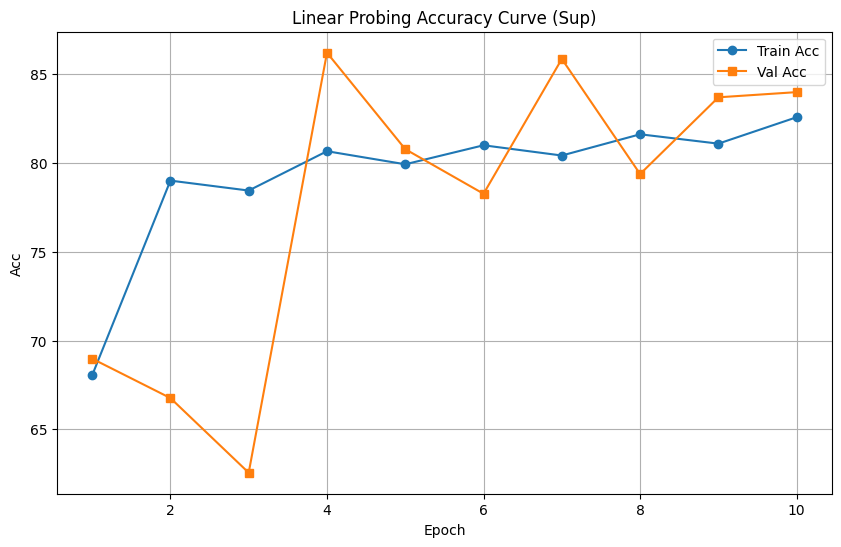

In [4]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(sup_model, train_loader, criterion, optimizer, device)
    val_acc = validate(sup_model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Val Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve (Sup)')
plt.legend()
plt.grid(True)

plt.show()

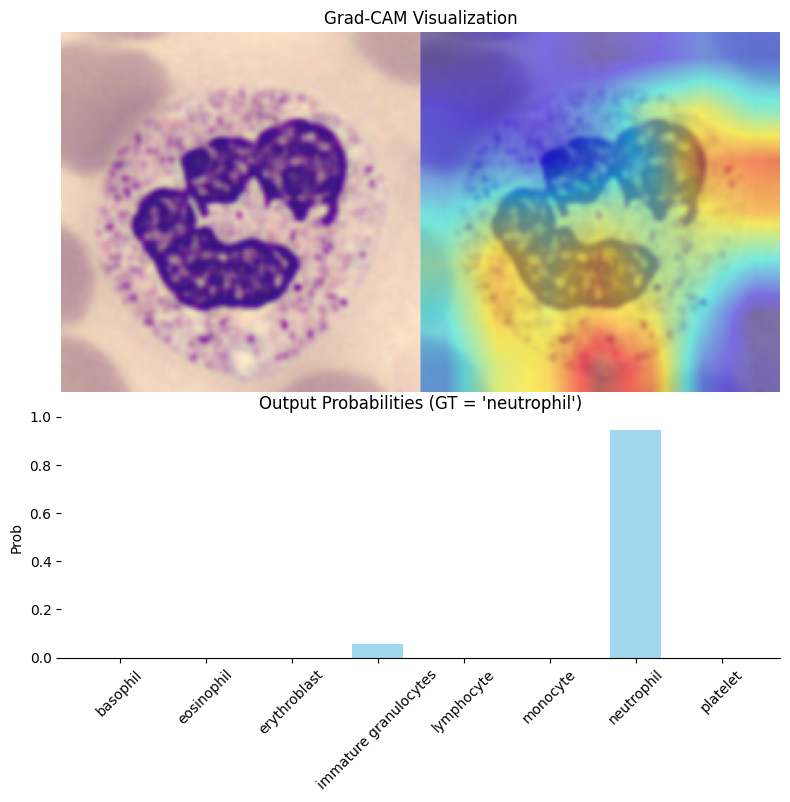

In [5]:
class_names = list(bloodmnist_label.values())

vis_res, output_probs, label = grad_cam_vis(sup_model, val_loader, img_idx=88)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vis_results/cam_vis_sup_res50.png')
plt.show()

# Finetune last linear layer with a self-supervised pretrained backbone (SimSiam)

In [18]:
"""
Download pre-trained SimSiam model from the following github repo:
https://github.com/facebookresearch/simsiam/tree/main
"""
simsiam_save_path = "/h/lkcai/code/csc_pj_ckpts/checkpoint_0099.pth.tar"
simsiam_state_dict = torch.load(simsiam_save_path)['state_dict']

new_state_dict = {k.replace('module.', ''): v for k, v in simsiam_state_dict.items()}
encoder_state_dict = {
    k.replace('encoder.', ''): v for k, v in new_state_dict.items() if k.startswith('encoder.')}

simsiam_model = resnet50()
simsiam_model.load_state_dict(encoder_state_dict, strict=False)

for name, param in simsiam_model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

simsiam_model.fc = nn.Linear(simsiam_model.fc.in_features, num_classes)
simsiam_model.fc.weight.data.normal_(mean=0.0, std=0.01)
simsiam_model.fc.bias.data.zero_()

criterion = nn.CrossEntropyLoss()

parameters = list(filter(lambda p: p.requires_grad, simsiam_model.parameters()))
optimizer = optim.Adam(parameters, 0.01)

simsiam_model = simsiam_model.to(device)

# pre-trained classifier with random head
val_acc = validate(simsiam_model, val_loader, device)
print(f"Self-Sup Pretrained Classifier with Random head - Val Acc: {val_acc:.2f}% ")

Self-Sup Pretrained Classifier with Random head - Val Acc: 27.92% 


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]


[Epoch 1/10]: Train Loss: 1.7950 Train Acc: 45.46% | Val Acc: 52.34%


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]


[Epoch 2/10]: Train Loss: 1.4594 Train Acc: 62.30% | Val Acc: 61.21%


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]


[Epoch 3/10]: Train Loss: 1.2369 Train Acc: 69.38% | Val Acc: 67.76%


100%|██████████| 187/187 [01:17<00:00,  2.42it/s]


[Epoch 4/10]: Train Loss: 1.0750 Train Acc: 75.48% | Val Acc: 73.77%


100%|██████████| 187/187 [01:16<00:00,  2.46it/s]


[Epoch 5/10]: Train Loss: 0.9616 Train Acc: 79.18% | Val Acc: 77.57%


100%|██████████| 187/187 [01:19<00:00,  2.35it/s]


[Epoch 6/10]: Train Loss: 0.8726 Train Acc: 80.73% | Val Acc: 79.85%


100%|██████████| 187/187 [01:18<00:00,  2.39it/s]


[Epoch 7/10]: Train Loss: 0.8086 Train Acc: 82.25% | Val Acc: 81.78%


100%|██████████| 187/187 [01:17<00:00,  2.40it/s]


[Epoch 8/10]: Train Loss: 0.7532 Train Acc: 82.91% | Val Acc: 83.35%


100%|██████████| 187/187 [01:17<00:00,  2.41it/s]


[Epoch 9/10]: Train Loss: 0.7042 Train Acc: 84.19% | Val Acc: 84.58%


100%|██████████| 187/187 [01:17<00:00,  2.40it/s]


[Epoch 10/10]: Train Loss: 0.6564 Train Acc: 85.22% | Val Acc: 84.75%


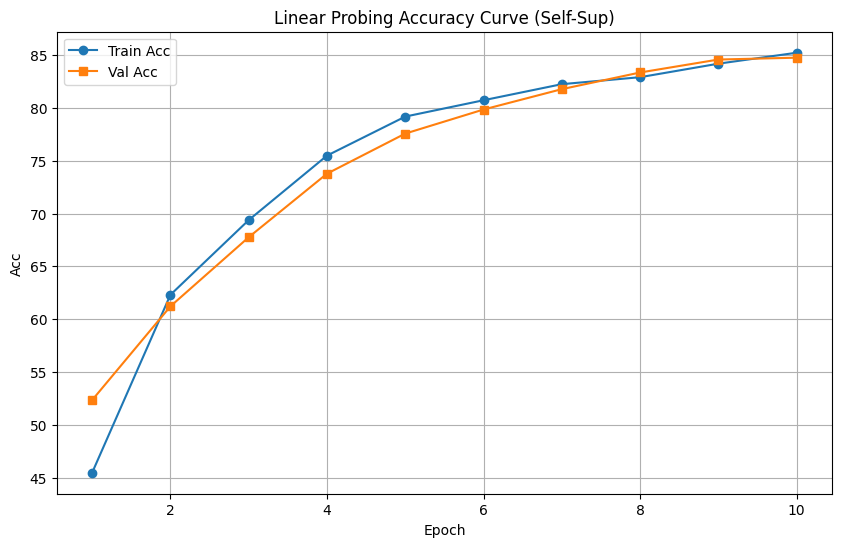

In [19]:
num_epochs = 10

train_acc_list = []
val_acc_list = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(simsiam_model, train_loader, criterion, optimizer, device)
    val_acc = validate(simsiam_model, val_loader, device)
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    print(f"[Epoch {epoch + 1}/{num_epochs}]: " + \
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Val Acc', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Linear Probing Accuracy Curve (Self-Sup)')
plt.legend()
plt.grid(True)

plt.show()

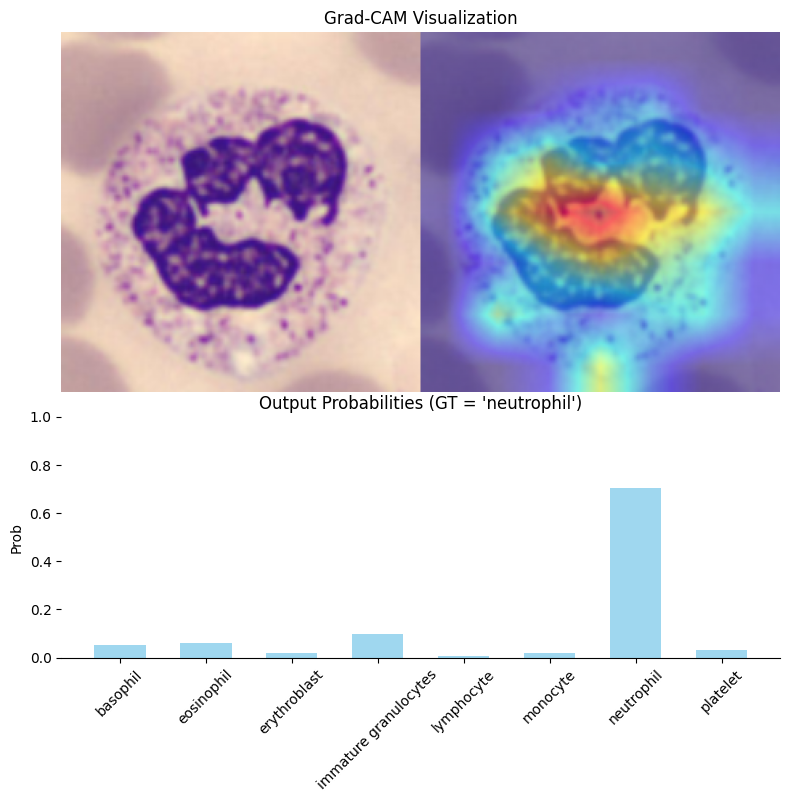

In [20]:
class_names = list(bloodmnist_label.values())

vis_res, output_probs, label = grad_cam_vis(simsiam_model, val_loader, img_idx=88)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 2]})

axes[0].imshow(vis_res)
axes[0].axis('off')
axes[0].set_title(f"Grad-CAM Visualization")

axes[1].bar(class_names, output_probs, color='skyblue', alpha=0.8, width=0.6)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

axes[1].set_ylim([0, 1])
axes[1].set_ylabel("Prob")
axes[1].set_title(f"Output Probabilities (GT = '{class_names[label]}')")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vis_results/cam_vis_selfsup_res50.png')
plt.show()